In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import time
import sys
import os
import h5py
import copy
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn 
import torch.optim as optim
from torchnet.dataset import ListDataset, BatchDataset
from torchnet.dataset.dataset import Dataset
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from version_model.model_list import *
from model_structure import save_model_structure
from plotting import plottingLossAcc, roc, Significance, Draw_Eff_Sig, CnnOutputs, plottingEff
from save_log import save_log, save_efficiency

In [2]:
bins = {}
# normtype : minmax or std
normtype = 'std'
for i in range(1,9):
    bins[i] = np.load("/home/jua/SWGO/square/data/{}/bin/bin{}.npz".format(normtype, i))    

In [3]:
nGevent = [0,83300, 41659, 19998, 8087, 3174, 1004, 272, 32, 0]
nPevent = [0,81720, 42929, 21366, 8932, 3419, 1035, 182, 9, 0]

In [4]:
n = 1
upperlower = 'upperlower'
#images = bins[n]['image'][:,0:2]
images = bins[n]['image']

images = torch.tensor(images).float()
labels = torch.cat((torch.ones(nGevent[n]),torch.zeros(nPevent[n])))
#labels = torch.tensor(labels).float()

sets = [(images[i],labels[i]) for i in range(len(labels))]
shuffle(sets)

In [5]:
train_sets = sets[:int(len(sets)*0.7)]
valid_sets = sets[int(len(sets)*0.7):int(len(sets)*0.85)]
test_sets = sets[int(len(sets)*0.85):]

In [6]:
batchsize = 512
trainloader = torch.utils.data.DataLoader(train_sets, batch_size=batchsize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_sets, batch_size=batchsize, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_sets, batch_size=batchsize, shuffle=True, num_workers=2)
dataloader = {'train':trainloader, 'valid':validloader, 'test':testloader}
datasize = {'train': len(train_sets), 'valid':len(valid_sets), 'test':len(test_sets)}

In [7]:
print('# of Train : {}, # of valid : {}, # of Test : {}'.format(datasize['train'],datasize['valid'],datasize['test']))

# of Train : 115513, # of valid : 24754, # of Test : 24753


In [8]:
def rotationImage(i, images, inputsize):
    copyImage = copy.deepcopy(images)
    if i%4 == 0:
        for i in range(len(copyImage)):
            for j in range(inputsize):
                copyImage[i][j] = torch.rot90(copyImage[i][j],1)
        return copyImage
    elif i%4 == 1:
        for i in range(len(copyImage)):
            for j in range(inputsize):
                copyImage[i][j] = torch.rot90(copyImage[i][j],2)
        return copyImage
    elif i%4 == 2:
        for i in range(len(copyImage)):
            for j in range(inputsize):
                copyImage[i][j] = torch.rot90(copyImage[i][j],3)
        return copyImage
    else:
        return copyImage

In [9]:
def flipImage(i, images, inputsize):
    copyImage = copy.deepcopy(images)
    if i%2 == 0:
        for i in range(len(copyImage)):
            for j in range(inputsize):
                copyImage[i][j] = torch.flip(copyImage[i][j],[0])
        return copyImage
    else:
        return copyImage

In [10]:
def augmentation(i, images, inputsize):
    copyImage = copy.deepcopy(images)
    copyImage = flipImage(i,copyImage, inputsize)
    copyImage = rotationImage(i//2,copyImage, inputsize)
    return copyImage

In [11]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        # print('Reset parameters of Linear')
        m.reset_parameters()

def freeze_conv(m):
    if isinstance(m, nn.Conv2d):
        # print('Freeze parameters of Conv2d')
        m.weight.requires_grad = False
        if m.bias is not None:
            m.bias.requires_grad = False

In [12]:
net = Model6()
#if upper only
#net.layer1[0] = nn.Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
device=torch.device('cuda')
net.to(device)
net.eval()

Model6(
  (layer1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, k

In [13]:
learning_rate = 0.00001
#learning_rate = 0.00003
# if sgd :learning_rate = 0.00003
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,verbose=True,patience=14)

In [14]:
threshold = 0.5
inputsize = 4
classes = {0:'proton',1:'gamma'}

In [15]:
def train_model(net, dataloader, criterion, optimizer, scheduler, n, batchsize, num_epochs=1, device=torch.device('cuda')):
    
    since = time.time()
    best_net_wts = net.state_dict()
    best_acc = 0.0
    threshold = 0.5
    losses = {'train':[],'valid':[]}
    accuracy = {'train':[],'valid':[]}
    
    for epoch in range(num_epochs):
        print( )
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train':
                net.train(True)
            else:
                net.eval()
                
            running_loss = 0.0
            running_corrects= 0
            ep_running_loss = 0.0
            ep_running_corrects = 0
            device = torch.device('cuda')
            for i, data in enumerate(dataloader[phase]):
                inputs, labels = data[0].to(device), data[1].to(device)
                if phase=='train':
                    optimizer.zero_grad()
                    inputs = augmentation(i%8, inputs, inputsize)
                logits = net(inputs)
                outputs = logits.sigmoid()
                #outputs = net(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs>threshold
                loss = criterion(logits, labels.view(-1,1).float())
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                                       
                running_loss += loss.data
                ep_running_loss += loss.data
                target = labels.view(-1,1)>threshold
                running_corrects += torch.sum(preds==target)
                ep_running_corrects += torch.sum(preds==target)
                               
                # Tensor Board 
                n_times = 10
                if i%n_times==9:
                    writer.add_scalar('{} loss'.format(phase),
                                     running_loss/(n_times),
                                     epoch*len(dataloader[phase])+i)
                    writer.add_scalar('{} Accuracy'.format(phase),
                                     float(running_corrects)/(n_times*batchsize),
                                     epoch*len(dataloader[phase])+i)                  
                    running_loss = 0.0
                    running_corrects = 0
                
            writer.close()
            epoch_loss = float(ep_running_loss)/float(len(dataloader[phase]))
            epoch_acc = float(ep_running_corrects)/float(datasize[phase])
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)
            #if epoch%6==0:
            print('{} Loss: {:.4f}, Acc : {:.4f}'.format( phase, epoch_loss, epoch_acc))    
            if phase == 'valid':
                scheduler.step(losses['valid'][-1])
                #scheduler.step()
            if phase=='valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_net_wts = net.state_dict()
        
    print()
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best Acc: {:4f}".format(best_acc))
    net.load_state_dict(best_net_wts)
    if best_acc > 0.9:
        modellogdir = "save_model/best/best_B{}_512".format(n) + now.strftime("%Y%m%d-%H%M%S") + ".pth"
        #torch.save(net.state_dict(), modellogdir)
        save_log(losses, accuracy, num_epochs, n, upperlower)
        #save_model_structure(net, '5')
    return net,losses,accuracy,best_acc 

In [16]:
def test(testloader,batchsize,device=torch.device('cuda')):
    correct = 0
    total = 0
    y_score = np.array([])
    y = np.array([])
    test_losses = []
    outs = []
    labs = []
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.view(-1,1)
        logits = net(inputs)
        outputs = logits.sigmoid()
        preds = outputs>threshold     
        loss = criterion(logits, labels.view(-1,1).float())
        y_score = np.append(y_score,outputs.data.cpu().detach().numpy())
        y = np.append(y,labels.cpu().numpy())
        test_losses.append(loss.data/batchsize)
        total += labels.size(0)
        target = labels.view(-1,1)>threshold
        correct += torch.sum(preds==target)
        outs.append(outputs.data.cpu().detach().numpy())
        labs.append(labels.data.cpu().detach().numpy()) 
    return y, y_score, correct, total, test_losses, outs, labs

In [17]:
from datetime import datetime
now = datetime.now()
logdir = "runs/bin{}/".format(n) + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(logdir)
net,losses,accuracy,best_acc = train_model(net, dataloader, criterion, optimizer,exp_lr_scheduler, n, batchsize, 200)


Epoch 0/199
----------
train Loss: 0.5725, Acc : 0.7106
valid Loss: 0.4688, Acc : 0.7883

Epoch 1/199
----------
train Loss: 0.4397, Acc : 0.8015
valid Loss: 0.4302, Acc : 0.8101

Epoch 2/199
----------
train Loss: 0.4062, Acc : 0.8199
valid Loss: 0.4069, Acc : 0.8230

Epoch 3/199
----------
train Loss: 0.3847, Acc : 0.8307
valid Loss: 0.3883, Acc : 0.8330

Epoch 4/199
----------
train Loss: 0.3700, Acc : 0.8385
valid Loss: 0.3654, Acc : 0.8448

Epoch 5/199
----------
train Loss: 0.3591, Acc : 0.8448
valid Loss: 0.3771, Acc : 0.8382

Epoch 6/199
----------
train Loss: 0.3497, Acc : 0.8485
valid Loss: 0.3442, Acc : 0.8530

Epoch 7/199
----------
train Loss: 0.3417, Acc : 0.8526
valid Loss: 0.3369, Acc : 0.8563

Epoch 8/199
----------
train Loss: 0.3365, Acc : 0.8562
valid Loss: 0.3325, Acc : 0.8597

Epoch 9/199
----------
train Loss: 0.3287, Acc : 0.8604
valid Loss: 0.3297, Acc : 0.8580

Epoch 10/199
----------
train Loss: 0.3228, Acc : 0.8627
valid Loss: 0.3343, Acc : 0.8537

Epoch 11

train Loss: 0.2308, Acc : 0.9082
valid Loss: 0.2750, Acc : 0.8907

Epoch 91/199
----------
train Loss: 0.2312, Acc : 0.9080
valid Loss: 0.2478, Acc : 0.9004

Epoch 92/199
----------
train Loss: 0.2308, Acc : 0.9085
valid Loss: 0.2493, Acc : 0.9000

Epoch 93/199
----------
train Loss: 0.2299, Acc : 0.9088
valid Loss: 0.2663, Acc : 0.8908

Epoch 94/199
----------
train Loss: 0.2295, Acc : 0.9091
valid Loss: 0.2596, Acc : 0.8969

Epoch 95/199
----------
train Loss: 0.2288, Acc : 0.9096
valid Loss: 0.2531, Acc : 0.8973

Epoch 96/199
----------
train Loss: 0.2289, Acc : 0.9091
valid Loss: 0.2700, Acc : 0.8881

Epoch 97/199
----------
train Loss: 0.2276, Acc : 0.9104
valid Loss: 0.2510, Acc : 0.8988

Epoch 98/199
----------
train Loss: 0.2273, Acc : 0.9100
valid Loss: 0.2492, Acc : 0.8994

Epoch 99/199
----------
train Loss: 0.2264, Acc : 0.9108
valid Loss: 0.2653, Acc : 0.8897

Epoch 100/199
----------
train Loss: 0.2261, Acc : 0.9108
valid Loss: 0.2576, Acc : 0.8938

Epoch 101/199
--------

valid Loss: 0.2459, Acc : 0.9011

Epoch 178/199
----------
train Loss: 0.2194, Acc : 0.9139
valid Loss: 0.2474, Acc : 0.9006

Epoch 179/199
----------
train Loss: 0.2190, Acc : 0.9135
valid Loss: 0.2465, Acc : 0.9010

Epoch 180/199
----------
train Loss: 0.2191, Acc : 0.9138
valid Loss: 0.2480, Acc : 0.9009

Epoch 181/199
----------
train Loss: 0.2182, Acc : 0.9142
valid Loss: 0.2461, Acc : 0.9012

Epoch 182/199
----------
train Loss: 0.2188, Acc : 0.9145
valid Loss: 0.2458, Acc : 0.9009

Epoch 183/199
----------
train Loss: 0.2189, Acc : 0.9141
valid Loss: 0.2469, Acc : 0.9009

Epoch 184/199
----------
train Loss: 0.2194, Acc : 0.9145
valid Loss: 0.2459, Acc : 0.9011

Epoch 185/199
----------
train Loss: 0.2186, Acc : 0.9143
valid Loss: 0.2462, Acc : 0.9011

Epoch 186/199
----------
train Loss: 0.2192, Acc : 0.9144
valid Loss: 0.2461, Acc : 0.9008

Epoch 187/199
----------
train Loss: 0.2194, Acc : 0.9143
valid Loss: 0.2459, Acc : 0.9011

Epoch 188/199
----------
train Loss: 0.2189, A

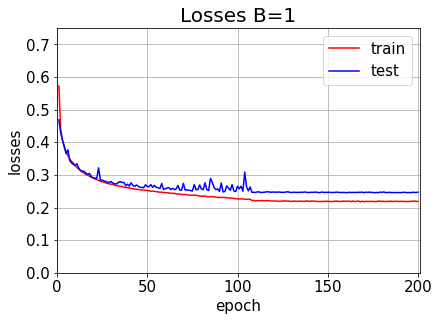

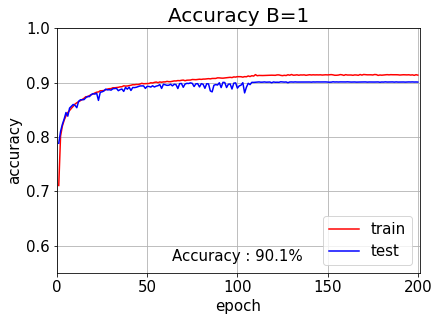

In [26]:
plottingLossAcc(losses,accuracy, n,(0,len(losses['train'])+1,0,0.75),
                (0,len(accuracy['train'])+1,0.55,1.0),round(best_acc*100,1),200,upperlower)

In [19]:
y,y_score,correct,total,test_losses,outputs,labels = test(dataloader['test'],batchsize)

Accuracy of the network on the 24753 test images: 90 %


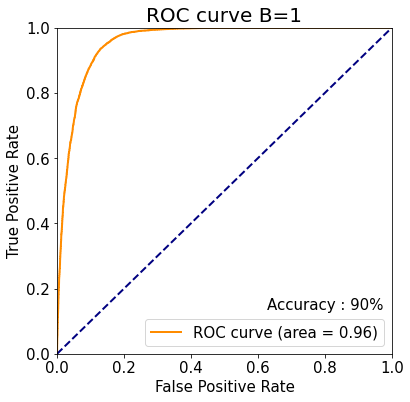

In [20]:
fpr, tpr, thresholds = roc(y,y_score,correct,total,n,upperlower)

In [21]:
new, s = Significance(thresholds, outputs, labels)

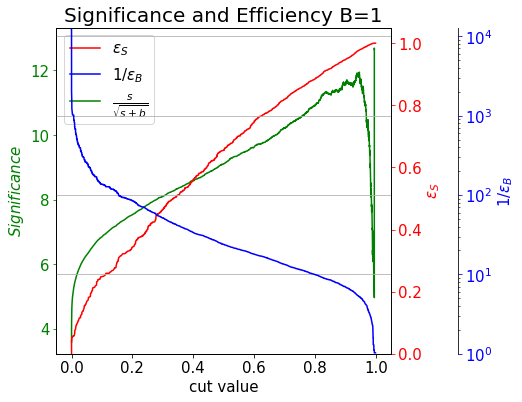

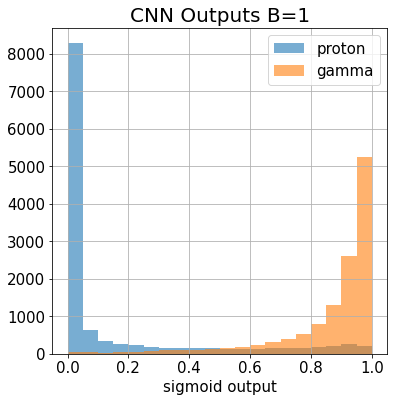

In [22]:
Draw_Eff_Sig(1/fpr[fpr!=0], tpr, s, thresholds, new, n,upperlower)
CnnOutputs(outputs, labels, n,upperlower)

In [23]:
'''
#efficiency 로 significance 구하기 
effsig = []
effthresholds = []
for f, t, threshold in zip(fpr, tpr, thresholds):
    if f==0: continue
    effsig.append(t/(f)**0.5)
    effthresholds.append(threshold)
Draw_Eff_Sig(1/fpr[fpr!=0], tpr, effsig, thresholds, effthresholds, n,upperlower)    
'''

'\n#efficiency 로 significance 구하기 \neffsig = []\neffthresholds = []\nfor f, t, threshold in zip(fpr, tpr, thresholds):\n    if f==0: continue\n    effsig.append(t/(f)**0.5)\n    effthresholds.append(threshold)\nDraw_Eff_Sig(1/fpr[fpr!=0], tpr, effsig, thresholds, effthresholds, n,upperlower)    \n'

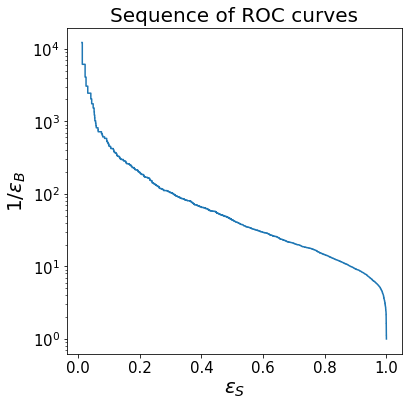

In [24]:
plottingEff(tpr, fpr, upperlower)

In [25]:
save_efficiency(tpr,fpr,n,upperlower)